# Tuto\#2 Explore the parameter space
In this tutorial, we are going to see how to explore the parameter space.

Fringes or nulling data have a $2 \pi$ degeneracy and a loss of temporal coherence when the OPD is too high which is degenerate with the astrophysical visibility.
The spectral dispersion lifts these degeneracy, and more easily when the spectral dispersion is high.

In any case, knowing the fringes where the data sit is critical.

Exploring the parameter space also allows to pave the limits of the model, in case some combinations of input parameters can return a NaN for instance.

GRIP allows a full flexibility in the parameter space:
- we can choose the cost function
- the estimator of the null estimator
- the boundaries of the parameter space

We will first load the data, create the histograms and prepare the model (like in Tuto \#1).

Then we will see how to do the exploration of the parameter space.

## Load data and get the histogram

In [1]:
import h5py
import numpy as np
import os

datafolder = 'dataset/'
darkfolder = datafolder
save_path = 'results/'

In [2]:
import grip
try:
    import cupy as cp # To use the GPU to speed up the process
except ModuleNotFoundError:
    import numpy as cp # If no GPU, we load numpy again with the same acronym to still use the functions


wl_min, wl_max = 11000, 11200
dark_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max))
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'intraphase_rms'], (wl_min, wl_max))

wl_scale = data['wl_scale']
dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']
Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

# Calculate the null depth
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5 # Using the estimator above
data_null = Iminus / Iplus # Calculated null depth

# Get the histogram
bin_bounds = (-0.01, 0.1) # Minimum and maximum values of the bins of the histogram
normed=True # We want to normalise the histogram by its sum

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed)

injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))
nb_frames_binning_photometry = -1 # Bin over all the sample
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)


data_IA_axis = cp.linspace(injection[0].min(), injection[0].max(),
                           np.size(np.unique(injection[0])),
                           dtype=cp.float32)
cdf_data_IA = grip.computeCdf(data_IA_axis, injection[0], 'cdf', True)
cdf_data_IA = cp.array(cdf_data_IA, dtype=cp.float32)

data_IB_axis = cp.linspace(injection[1].min(), injection[1].max(),
                           np.size(np.unique(injection[1])),
                           dtype=cp.float32)
cdf_data_IB = grip.computeCdf(data_IB_axis, injection[1], 'cdf', True)
cdf_data_IB = cp.array(cdf_data_IB, dtype=cp.float32)

sigma_eps = data['intraphase_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

rvu_opd = None # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Uncomment the lines below to play with "deterministic" Monte-Carlo
# rvu_opd = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IA = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IB = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_bg = cp.random.uniform(0, 1, size=(wl_scale0.size, n_samp_per_loop), dtype=cp.float32)
# rvu_eps = cp.random.uniform(0, 1, size=(wl_scale0.size, n_samp_per_loop), dtype=cp.float32)

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]

n_samp_total = int(1e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop

dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


## Explore the parameter space
Now, let's dive into the core of this tutorial.

We will use the negative binomial lilelihood as a cost function.
As a reminder, the number of elements in the bins follow a binomial distribution.
The code can be used in the same way with a $\chi^2$ cost function.

The null estimator is:
$ N = \frac{I_{-}}{I_{+}} $

$I_{-}(\lambda) =I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)} |V| \cos(\frac{2\pi}{\lambda} \Delta OPD) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^2_\epsilon) + B(\lambda)$

$I_{+}(\lambda) = I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)}$

- $I_x$ is the intensity of the output
- $\Delta OPD$ is the phase of the fringe due to atmospheric turbulence, the phase is centered around $\pi$
- $\sigma_\epsilon$ is the standard deviation of the phase within an exposure time, thus doing fringe blurring
- $B$ is the thermal background

The LBTI does not record the bright fringe, the paper uses an ah hoc expression:

The parameters to explore are:
- the astrophysical null depth ($N_a = \frac{1-|V|}{1+|V|}$)
- the location $\mu$ and
- the scale $\sigma$ of the normal distribution describing the statistics of the fluctuations of phase $\Delta \phi$.

We define the minimum and maximum values for these parameters, and the number of points to sample each parameter axis.

In [3]:
bounds_mu0 = (0, 800) # Boundaries of mu opd
bounds_sig0 = (200, 400) # Boundaries of sig opd
bounds_na0 = (0.0, 0.01) # Boundaries of Na
param_bounds = [bounds_na0, bounds_mu0, bounds_sig0] # Pack those into a list

map_na_sz = 20 # Number of points to explore along the null axis
map_mu_sz = 50 # Number of points to explore along the mu opd axis
map_sig_sz = 10 # Number of points to explore along the sig opd axis
param_sz = [map_na_sz, map_mu_sz, map_sig_sz] # Pack those into a list

The exploration is made with the function `fit_tools.explore_parameter_space(cost_fun, histo_data, param_bounds, param_sz, xbins, wl_scale0, instrument_model, instrument_args, rvu_forfit, cdfs, rvus, histo_err=None, **kwargs)`:
- `cost_fun`: cost function
- `histo_data`: histogram of the data
- `param_bounds`: boundaries of the parameters `param_bounds`
- `param_sz`: size of the axes to explore `param_sz`
- `xbins`: bin-axis of the histogram
- `wl_scale0`: wavelength scale
- `instrument_model`: null depth estimator (`lbti_model` here)
- `instrument_args`: arguments to pass to `instrument_model`
- `rvu_forfit`: list of uniform random values use to generate normally distributed values with the fitting parameters `mu` and `sig`
- `cdfs`: list of the CDF which are used to reproduce the statistics of the noises
- `rvus`: list of uniform random values use to generate random values to reproduce the statistics of the noises.
- `histo_err`: error bars on the data histograms. Useful if the cost function is a $\chi^2$, useless for `neg_log_multinomial`
- `**kwargs`: keywords to pass to `create_histogram_model`

The function returns several information:
- the mapped likelihood (`lklhmap`)
- the axes of the parameter space (`maps`)
- the step size of the sampling in the axes (`lklhsteps`)


In [4]:
# Keywords to pass to the function `create_histogram`:
# the number of samples per loop, the number of loop, the display of the number of occurences and the values of the parameters to fit, and not normalise the histograms
histo_fun_kwargs = {'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'verbose':False, 'normed':False}

spec_chan_width = 2600
instrument_constants = (spec_chan_width, np.pi)

lklhmap, maps, lklhsteps = grip.explore_parameter_space(grip.neg_log_multinomial, null_pdf, param_bounds, param_sz, 
                                                        null_axis, wl_scale, grip.lbti_model, instrument_constants, 
                                                        rvu_opd, cdfs, rvus, null_pdf_err, **histo_fun_kwargs)

/mnt/96980F95980F72D3/grip/grip/fit_tools.py:94: RuntimeWarning: divide by zero encountered in log
  stirling = n * np.log(n) - n
/mnt/96980F95980F72D3/grip/grip/fit_tools.py:94: RuntimeWarning: invalid value encountered in multiply
  stirling = n * np.log(n) - n
/mnt/96980F95980F72D3/grip/grip/fit_tools.py:142: RuntimeWarning: divide by zero encountered in log
  logmodel = np.log(model)


Duration: 165.270 s


This operation can be long as there are 3 parameters to explore. While increasing `n_samp_per_loop` does not have a huge impact on the duration of the process (thanks to the GPU or Numpy), increasing `nloop` linearly increases the duration.

We can then extract some information from the map like the two first minima.
It allows to check if the astrophysical null depth found is consistent with the expected value from a preliminary analysis (e.g get the stellar radius from the catalogs).

In [5]:
map_na, map_mu_opd, map_sig_opd = maps
step_na, step_mu, step_sig = lklhsteps

lklhmap2 = lklhmap.copy()
lklhmap2[np.isnan(lklhmap2)] = np.nanmax(lklhmap)
argmin = np.unravel_index(np.argmin(lklhmap2), lklhmap2.shape)
print('Min in param space', lklhmap2.min(), map_na[argmin[0]],
      map_mu_opd[argmin[1]], map_sig_opd[argmin[2]])
print('Indexes are:', argmin)
fake = lklhmap2.copy()
fake[argmin] = lklhmap2.max()
argmin2 = np.unravel_index(np.argmin(fake), lklhmap2.shape)
print('2nd min in param space',
      lklhmap2[argmin2], map_na[argmin2[0]],
      map_mu_opd[argmin2[1]], map_sig_opd[argmin2[2]])
print('Indexes are:', argmin2)

Min in param space 33.694777638931576 0.007 16.0 340.0
Indexes are: (14, 1, 7)
2nd min in param space 33.69489904244741 0.007 0.0 340.0
Indexes are: (14, 0, 7)


We can display the parameter space.
The map is 3-dimensional thus we need 3 2d projection to grasp the whole map.

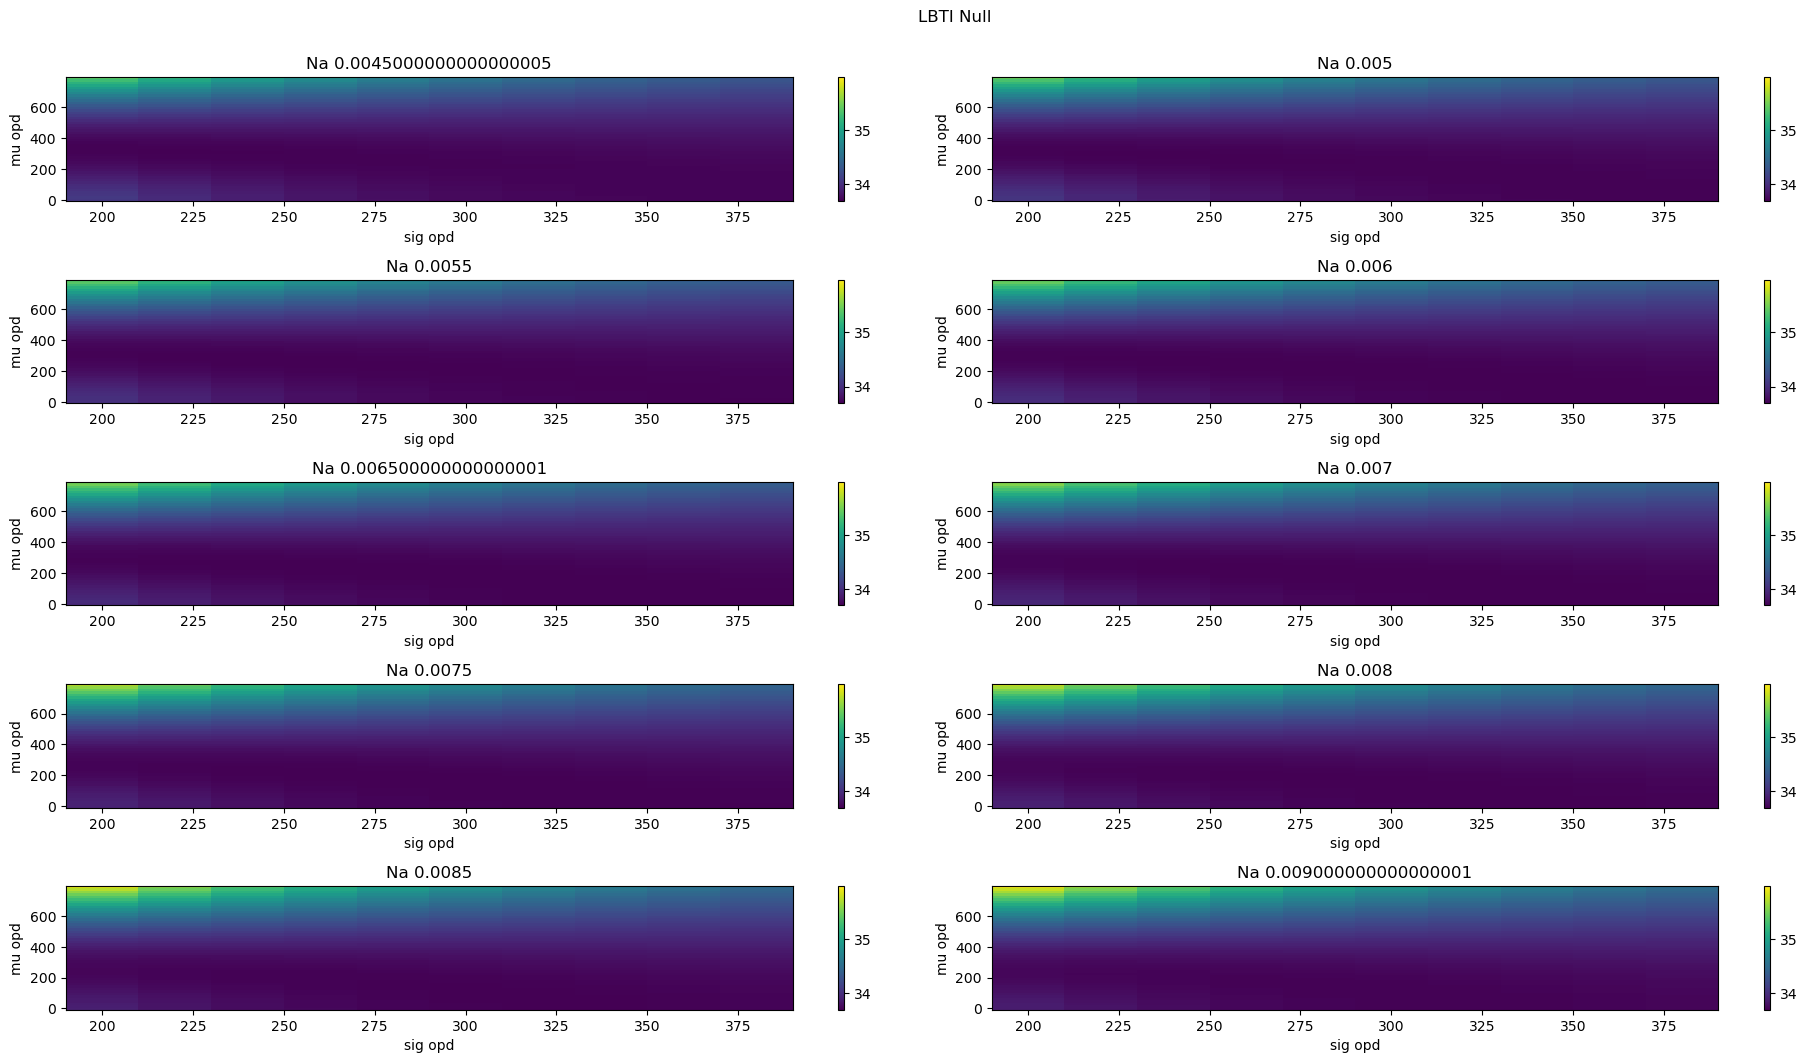

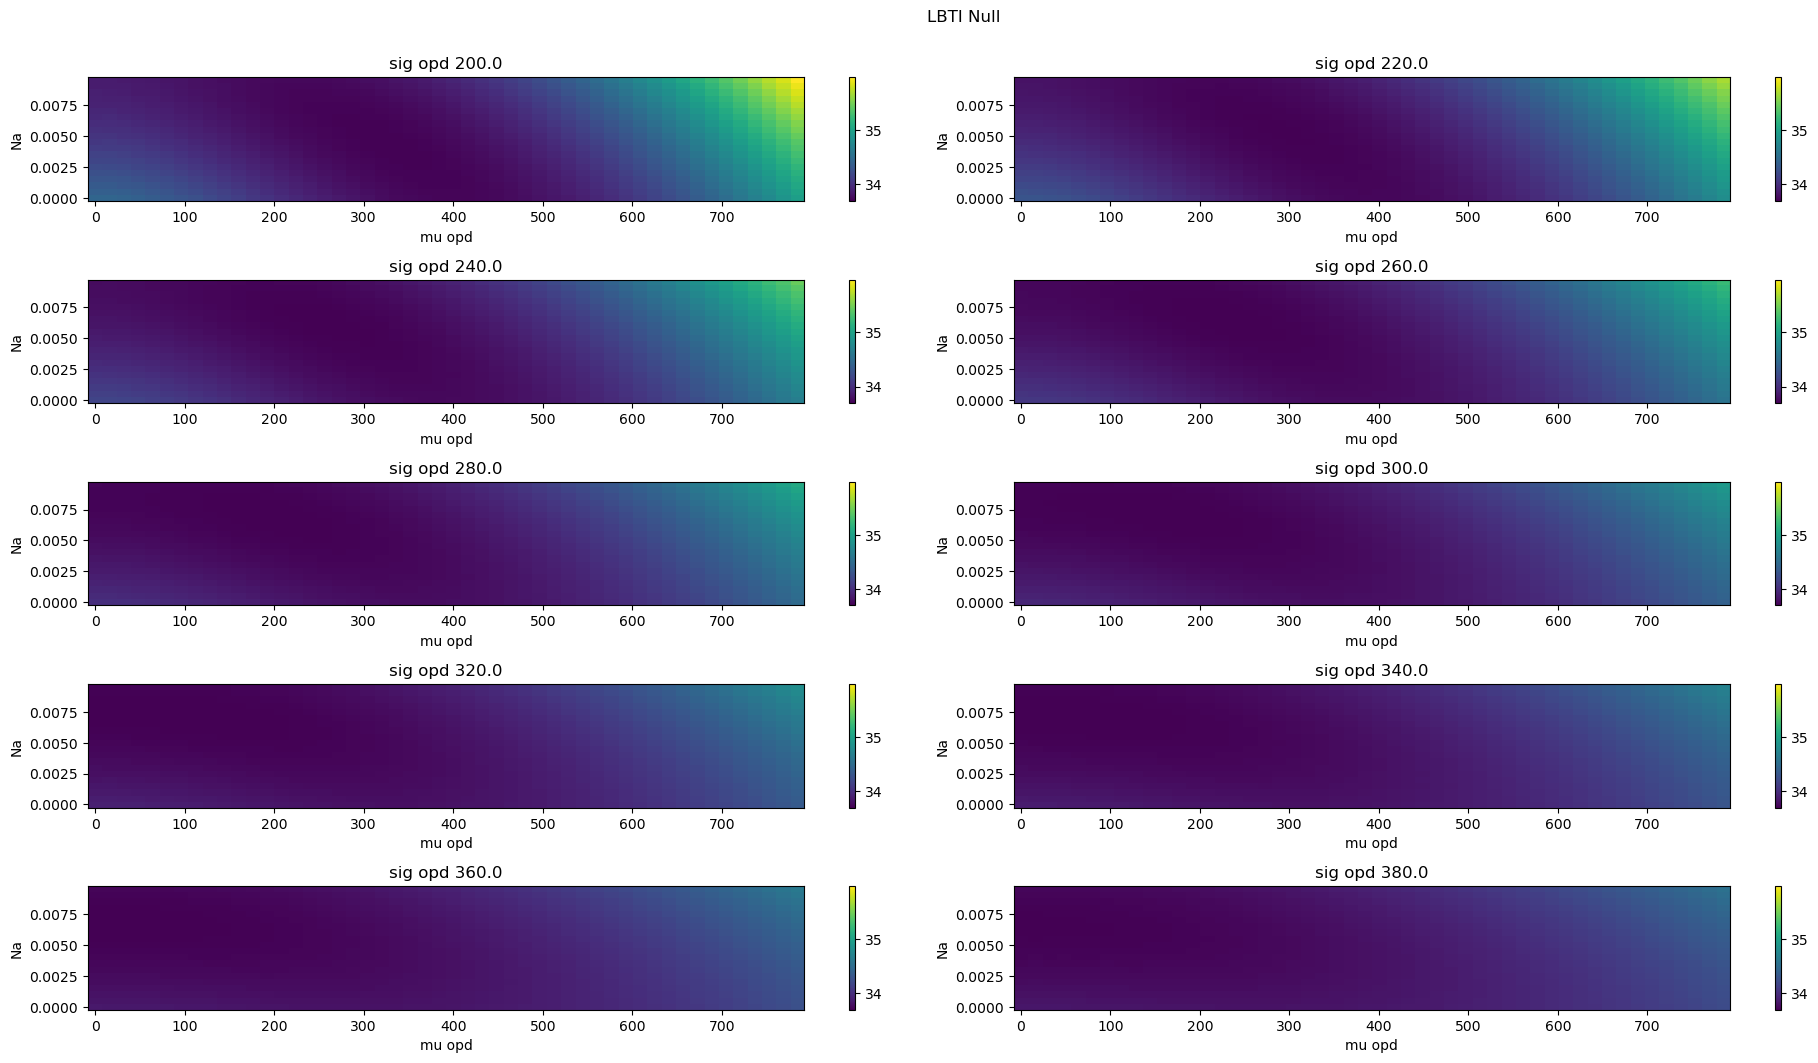

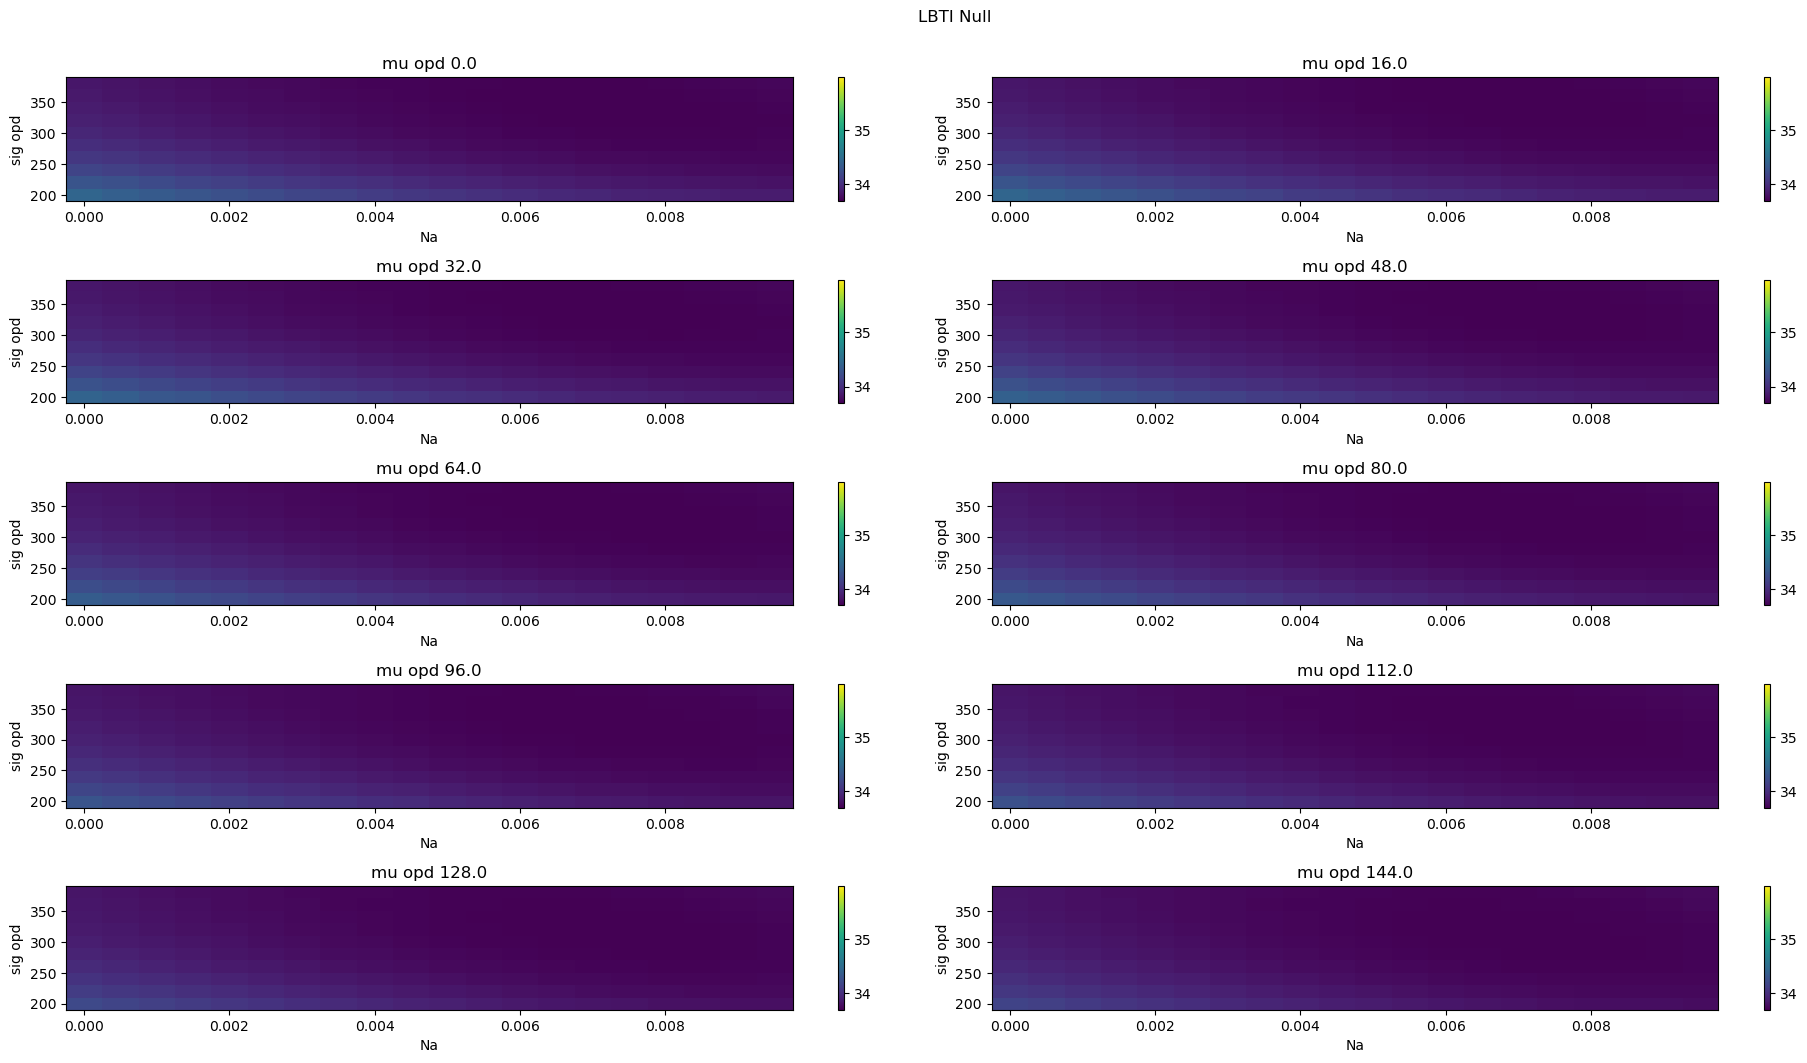

In [6]:
key = 'LBTI Null'
grip.plot_parameter_space_2d(lklhmap, map_sig_opd, map_mu_opd, map_na, argmin[0],
                          step_sig, step_mu,'sig opd',  'mu opd', 'Na', key,
                          save_path, 'mu', 'sig', 0,
                          wl_min, wl_max, True)

lklhmap2 = np.transpose(lklhmap, axes=(2,0,1)) # z=sig, x=mu, y=na
grip.plot_parameter_space_2d(lklhmap2, map_mu_opd, map_na, map_sig_opd, argmin[2],
                          step_mu, step_na, 'mu opd', 'Na', 'sig opd', key,
                          save_path, 'na', 'mu', 0,
                          wl_min, wl_max, True)

lklhmap3 = np.transpose(lklhmap, axes=(1,2,0)) # z=mu, x=na, y=sig
grip.plot_parameter_space_2d(lklhmap3, map_na, map_sig_opd, map_mu_opd, argmin[1],
                          step_na, step_sig, 'Na', 'sig opd', 'mu opd', key,
                          save_path, 'sig', 'na', 0,
                          wl_min, wl_max, True) 

### Congratulations, we made it until here!

### We know how to explore the parameter space.